<a href="https://colab.research.google.com/github/poojamahajan0712/COVID_tweet_analysis/blob/master/Covid_Tweet_Analysis_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing required libraries
#!pip install contractions
#!pip install wordcloud==1.8.0
import pandas as pd
import seaborn as sns
import contractions
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 600

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Loading Dataset



In [2]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [3]:
# shape of the data
df.shape


(41157, 6)

#2. Exploring Data 

In [4]:
# Missing values present ---- missing values present in Location column
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [5]:
## Number of uniques for each column-- data for 30 days of tweet, unique locations 12220
df.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

In [17]:
# min and max dates 
df['TweetAt']=pd.to_datetime(df['TweetAt'],dayfirst=True)
print('Minimum date',df['TweetAt'].dt.date.min())
print('Maximum date',df['TweetAt'].dt.date.max())


Minimum date 2020-03-16
Maximum date 2020-04-14


In [7]:
df['Location'].unique()[:60]  ## some funny locations present too!!

array(['London', 'UK', 'Vagabonds', nan, 'Ã\x9cT: 36.319708,-82.363649',
       '35.926541,-78.753267', 'Austria', 'Atlanta, GA USA',
       'BHAVNAGAR,GUJRAT', 'Makati, Manila', 'Pitt Meadows, BC, Canada ',
       'Horningsea', 'Chicago, IL', 'Houston, Texas', 'Saudi Arabia',
       'Ontario, Canada', 'North America', 'Denver, CO',
       'southampton soxx xxx', 'Global', 'Downstage centre',
       'Ketchum, Idaho', 'Everywhere You Are!', 'New York, NY',
       'Someplace, USA', 'Markham, Ontario', 'Virginia, USA',
       'London, England', 'Sverige', 'Where The Wild Things Are',
       'Canada', 'United States', 'Fort Worth, Texas', 'Houston',
       'Vancouver, British Columbia', 'Midrand', 'Drogheda',
       'Columbia, MO', 'Arkansas, USA', 'Washington, DC', 'Ohio, USA',
       'Ogden, UT', 'West Midlands, England', 'Reno, NV', 'San Clemente',
       'Spokane Valley, WA', 'Drifter ', 'Hamilton, Ontario',
       'Dallas, TX', 'Boston', 'The European Union',
       'Melissa Schuman i

Positive              27.75
Negative              24.10
Neutral               18.73
Extremely Positive    16.10
Extremely Negative    13.32
Name: Sentiment, dtype: float64


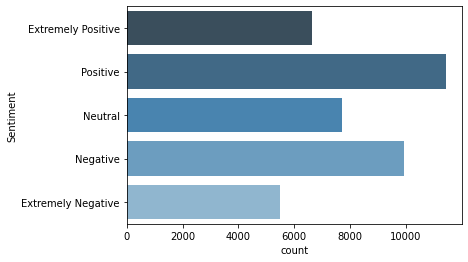

In [18]:
## Sentiment column distribution
print(round((df['Sentiment'].value_counts(normalize=True))*100,2))
sns.countplot(y=df['Sentiment'],palette="Blues_d",
              order=["Extremely Positive", "Positive","Neutral","Negative","Extremely Negative"])

In [9]:
## Text Cleaning  and steps -- some basic steps can be done 
df['OriginalTweet'].head()

# on checking tweets - we can see lot of special character tags , urls, contractions

0                                                                                                                                                                                                                       @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1                                                                                         advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                                                   Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
3     My food st

In [10]:
# creating a column as number of mentions
df['cnt_mentions']=df['OriginalTweet'].apply(lambda x :len([t for t in x.split() if t.startswith('@') ]))
df['cnt_mentions'].describe()

count    41157.000000
mean         0.416916
std          1.116992
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: cnt_mentions, dtype: float64

In [11]:
## so we saw max value for mentions is 21 , let's check how these tweets look like -- seems like all are just tags and thus can be removed.
df[df['cnt_mentions']==21]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cnt_mentions
22994,26793,71745,NaN,2020-03-25,@twigliot @DreaVilleneuve @tedbauer2003 @TheComicHunter @biggreenpen @MrLexJay @JimCanto @ideabloke @JoelRRenner @GabrielSurfCat @BrendaMKramer @YEPBusiness @katyb_spencer @joshmccormack @Renoe @bikespoke @nplusg @MattJ_O @plainwildcatfan @johndburger @ho,Neutral,21
31440,35239,80191,NaN,2020-04-06,@Jaisans @JamesRider3 @AanthanurDC @doom37455413 @ILuvCO2 @Andrewemcameron @geoffmprice @ElectroPig @glinch72 @IngersolRobert @AgtRigor @Bitakarma @AtomsksSanakan @DevinNunesGoat1 @Article3S @Jamz129 @rm_simmons @RustyAway @JosephsEddy @MikeH_MapleGrov @i,Neutral,21
31657,35456,80408,"North Carolina, USA.",2020-04-07,@ThomONeil1 @bobbiejaneV @media_auntie @BonJS0370 @ldog562 @zazzybritches @pecriel @kristyshl @HurricaneEve81 @MaryHow16 @SafiMaasai @alice4u2010 @ReneTremblay13 @stweetleigh @poppij @Dianne2429 @paulinef136 @mccunecicki @TilghmanChris @StaryStaryNlght @b,Neutral,21


In [12]:
df.drop(df[df['cnt_mentions'] >20].index , inplace=True)
df.shape

(41154, 7)

In [13]:
# creating a column as number of hashtags
df['cnt_hashtags']=df['OriginalTweet'].apply(lambda x :len([t for t in x.split() if t.startswith('#') ]))
#df[['cnt_hashtags','Sentiment']].head()
#df['cnt_hashtags'].describe()

# 3. Cleaning tweet data

In [14]:
# remove urls 
df['processed'] = df['OriginalTweet'].replace(r'http\S+', ' ', regex=True)

# convert to lowercase
df['processed']=df['processed'].str.lower()

# contractions
df['processed']=df['processed'].apply(contractions.fix)

## removing account names -- basically after @ words -- those are usernames
df['processed']=df['processed'].apply(lambda x :[t for t in x.split() if not t.startswith('@')] ).apply(lambda x: ' '.join(x))

## removing special characters and number
df['processed'] = df['processed'].replace(r'[^A-Za-z]+', ' ', regex=True)

## removing extra spaces 
df['processed']=df['processed'].apply(lambda x : x.strip())



In [15]:
## Number of words in tweet-  calculating length 
df['len']=df['processed'].apply(lambda x : len([ t for t in x.split()]))
df['len'].describe()

count    41154.000000
mean        29.447611
std         11.826769
min          0.000000
25%         20.000000
50%         30.000000
75%         39.000000
max         65.000000
Name: len, dtype: float64

#4.Wordcloud- Frequently occuring words 

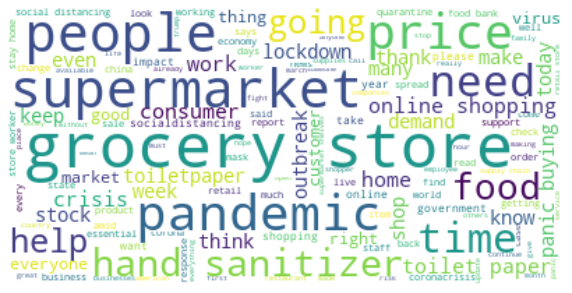

In [16]:
### create wordcloud 

text = " ".join(review for review in df['processed'])
stopwords = set(STOPWORDS)
stopwords.update(['covid','coronavirus','coronaviru','will','say','still','amp'])
#stopwords.update(['will','say','still','amp'])

wordcloud = WordCloud(stopwords=stopwords,background_color="white",min_word_length=4,collocation_threshold=20).generate(text)
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()